# Simulated Based Inference of  EEG by Generic Hopf model 

Here we first simulate a whole brain model of resting state, in which a generic Hopf bifurcation model is placed at each brain region, which are connected thriugh SC matrix (here, N=84). Then the aim is to invert the model using simulated-based-inference (SBI), in which a deep learning architecture known as normalizing flow is trained on the data features extracted from a large number of simulations (such as FC and FCD).

SBI provides a simple interface to run state-of-the-art algorithms for SBI families (SNPE/SNLE/SNRE) and normalizing flow (MDN/MAF/NSFs).

For inference, we need to provide three ingredients:

1) a prior distribution that allows to sample parameter sets.

2) a simulator that takes parameter sets as input and provides simulated data features as outputs.

3) Normazing flows in a SBI family to estimate a mapping function between input (parameters) and output (data feature). By providing the feature of empirical data, this provides the postrior distribution of parameters in tailot to Bayes's rule.

All the aforementioned ingredients needs to wrap up in a function which only takes parameters as input and return us the data features (stat-summary) of simulations.

To install SBI, see https://github.com/mackelab/sbi.

Refs: 

[1] Deco, Gustavo, et al. "The dynamics of resting fluctuations in the brain: metastability and its dynamical cortical core." Scientific reports 7.1 (2017): 1-14. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5465179/)


[2] Gonçalves, Pedro J., et al. "Training deep neural density estimators to identify mechanistic models of neural dynamics." Elife 9 (2020): e56261. (https://elifesciences.org/articles/56261)

[3] Cranmer, Kyle, Johann Brehmer, and Gilles Louppe. "The frontier of simulation-based inference." Proceedings of the National Academy of Sciences 117.48 (2020): 30055-30062. (https://www.pnas.org/content/117/48/30055)


### Set up

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
from numba import jit
import scipy as scp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer


from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, DirectPosterior, MCMCPosterior, VIPosterior

from sbi.analysis import pairplot
import sbi.utils as utils

In [3]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [4]:
from FCD import extract_FCD

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on sbi: v0.18.0


In [9]:
sns.set(style="white")
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [10]:
cwd = os.getcwd()
cwd

'/data/SBI/GenericHopf_SBI_GenericSC'

In [11]:
import warnings
np.seterr(all = 'ignore')
warnings.filterwarnings("ignore")

In [12]:
Res_dir='Res_SBI_BNM_GenericHopf_EEG_Demo_InferG_FCFCD_savesim1k_v18'

# Load the Human Connectome

First we load the connectivity matrix (here, 84 X 84) and we normalize it between [0,1].

In [13]:
weights= np.loadtxt(cwd+ '/ExperimentalData/hcp_001/weights.txt')

In [14]:
weights.shape, weights.min(), weights.max()

((84, 84), 0.0, 8706.0)

In [15]:
nn=weights.shape[0]
print  ('The number of regions  is: ', nn)

The number of regions  is:  84


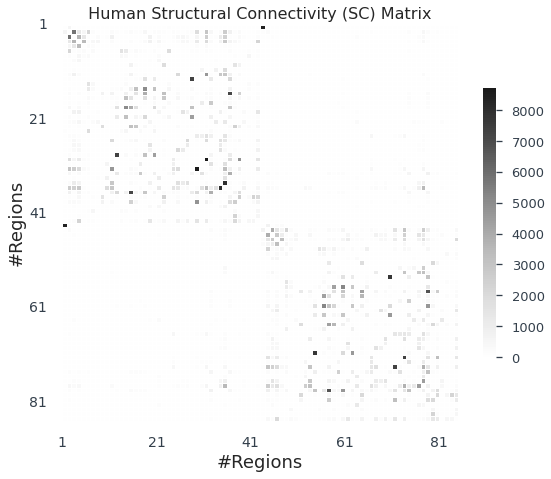

In [16]:
plt.figure(figsize=(8, 8))
mask = np.zeros_like(weights, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap='RdGy'
sns.heatmap(weights, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(' Human Structural Connectivity (SC) Matrix ',fontsize=16)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
plt.yticks(np.r_[0:nn][::20], np.r_[1:nn+1][::20], fontsize=14)
#plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix.eps"), doi=800)
plt.show()

In [17]:
con = weights/np.max(weights)

In [18]:
con.shape, con.min(), con.max()

((84, 84), 0.0, 1.0)

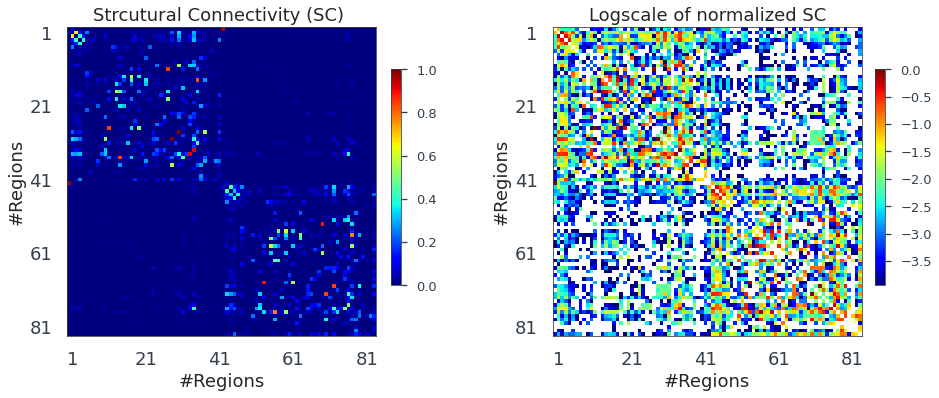

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
norm = colors.LogNorm(1e-7, con.max())
i=axs[0].imshow(con,cmap=cm.jet)
colorbar_ax = fig.add_axes([0.45, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[0].set_title('Strcutural Connectivity (SC) ', fontsize=18.0)
axs[0].set_ylabel('#Regions', fontsize=18.0)
axs[0].set_xlabel('#Regions', fontsize=18.0)
axs[0].tick_params(labelsize=18)
axs[0].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[0].yaxis.set_ticks(np.r_[1:nn+1][::20])

i=axs[1].imshow(np.log10(con),cmap=cm.jet)
colorbar_ax = fig.add_axes([.93, 0.3, 0.01, 0.5])
fig.colorbar(i, cax=colorbar_ax)
axs[1].set_title('Logscale of normalized SC', fontsize=18.0)
axs[1].set_ylabel('#Regions', fontsize=18.0)
axs[1].set_xlabel('#Regions', fontsize=18.0)
axs[1].tick_params(labelsize=18)
axs[1].xaxis.set_ticks(np.r_[1:nn+1][::20])
axs[1].yaxis.set_ticks(np.r_[1:nn+1][::20])

fig.tight_layout(pad=2)

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_Normalized.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCmatrix_Normalized.eps"), doi=800)
plt.show()

In the following, we place a generic Hopf bifurcation at each brain region connected through SC matrix to each others (see ref [1]). We use JIT compilation from numba for fast simulation (note that the first compilation is slow, then it will be on-the-fly to produce efficient machine code!).

### constants

In [20]:
eta_c=0       
delta_eta=.5                  
prior_std =1.0
sd_thr=0.5

# whole-brain network simulation

$  \frac{d x_i}{dt}= (\eta_i-x_i^2-y_i^2)x_i -\omega_i y_i+ G \sum_{j=1}^{N} C_{j,i} ( x_j- x_i) +\sigma \xi_i(t)$

$ \frac{d y_i}{dt}= (\eta_i-x_i^2-y_i^2)y_i +\omega_i x_i + G \sum_{j=1}^{N} C_{j,i} ( y_j- y_i)+ \sigma \xi_i(t)$


where $\eta_i$ is the excitability (bifurcation paremeter), $C_{i,j}$ is the ij-element of SC matrix, $G$ is a global scaling parameter, $\xi_i$ is additive Gaussian noise with standard deviation $\sigma$.

This normal form has a supercritical bifurcation at a $\eta=0$, so that for a $\eta < 0$ the local dynamics has a stable fixed point  (which because of the additive noise corresponds to a low activity asynchronous state) and for a $\eta > 0$ there exists a stable limit cycle oscillation with frequency $f_j = \omega/2\pi$.

The function "GenericHopfmodel" takes the (arbitary) inputs as $\eta \in \mathbb{R}^N$ (excitability), $\omega \in \mathbb{R}^N$ (intrinsic frequency), initial conditions for state-variables x and y (here same initial condition for all brain regons), $\sigma$ (the noise level), $G$ (global scaling parameter), $SC \in \mathbb{R}^{N \times N}$ (structral connectivity matrix), dt (time step for Euler integration here), ts (the length for simulation), and returns the $x \in \mathbb{R}^{N \times t}$ as the source brain activity). 

In [21]:
from GenericHopfModel import GenericHopfmodel

In this notebook, we generate the excitability parameters randomly from $\eta_i \sim \mathcal{N}(\mu,\,\sigma^{2})$, and the aim of inference is to estimate one parameter the global scaling parameter $G$. 

The function "GenericHopfEEG" contains the both Generic Hopf model and "BalloonWindkessel". Here ds is the downsampling from source level to EEG signal. The dimention of output EEG signals is $nn \times nt_{EEG}$, where $nn$ is the number of brain regions and $nt_{EEG}=int(nt/ds)$ is the number of data points at measurement (EEG) level for each region.

In [22]:
from GenericHopfModel_features import calculate_summary_statistics

The function "calculate_summary_statistics" provides the data features  of simulated data (dimention reduction step). 
This function takes the simulated EEG signals (with dimention $nn \times nt_{EEG}$), with $nn$ as the number of brain regions and the (user-defined) features as the time invariant statistical moments including mean, median, std, skew, kurtosis, independently for each node. It also provides higher_moments (by order of ten), spectral_power, envelope (calculated from hilbert function), as well as summary statistics of functional connectivity (FC_corr based on pearson correlation) and functional connectivity dynamic (FC_corr using sliding window) such as sum, max, off-diagonal, eigen_vals and PCA. The output (sum_stats_vec) is vectorized for SBI. Note that for SBI, the input parameter set should have either shape (1,N) or (N), and the output must have shape (1,M) or (M).

This function is arbitrary and task dependent. The samller dimention of data features will require the less computational time for the NN training, but it should be sufficiently informative to provide accurate posteriors with proper level of shrinkages (the non-relevant features just yield in waste of the time and the posterior remains close to the prior, i.e., no shrinkage due to no loss without any algorithmic diagnostics or error!). For each inverse problem, it is required to investigate which data feature (e.g., FC or FCD) required the less number of simulation to obtain informative posterior or even whether it is relevant to the parameter of interest for estimation.  

Finally, we wrap all the functions for foward simulation (e.g., "GenericHopfEEG" and "calculate_summary_statistics" if one does not aim to save simulations), as well as the relevent constant values. This  wrapper function should only takes the parameters as the input, but output can be flatten raw data or data features. Having more arameters to estimate, thus the more number of simulations, it is recommended to save data features (stat-summary) for SBI as the simulator output to avoid the memory issue. In this example, due to the low computational cost and memory for estimation only one parameter, we first save the raw time series from simulator, then we load them, calculate the features and finnaly run the SBI. This allows us to debug the problem of feature calculation for training step (e.g. NAN/INF devision by zero, or imaginary values. Note, if simulation diverges, SBI training by defulat will ignore NAN/INF but some mathematical operation on them may yield an error). 

In [23]:
@jit(nopython=False)
def GenericHopf_simulator_wrapper(params):
    
    params = np.asarray(params)
    
    ## fixed values: simulation time lenght (T), the time step (dt), the array of time points (ts),  
    ##  noise level (sigma), time step for BalloonWindkessel, downsampling (ds). 
    
    Tmax = 20.0
    dt=0.0001
    ts = np.arange(0, Tmax + dt, dt)
    sigma=1e-1


    ## initial conditions
    x_init=0
    y_init=0
    init_conditions = np.array([x_init, y_init])

    ##param : global coupling parameter (G)
    params_G=params[0]
    
    nn=SC.shape[0]
    
    Simulated_EEG = GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, params_G, SC, dt, Tmax)

    #summstats = torch.as_tensor(calculate_summary_statistics(EEG_simulated, nn, features=['FC_corr', 'FCD_corr']))

    return Simulated_EEG 

### some simulations for  sanity check


In the following, we first just perform a sanity check on the simulation step providing us the FC/FCD.
It is always useful to run some simulations before the inference (as a prior predictive check) on the plausible range of parameters such as dt and G (for high values of dt and G, the euler integraion will diverge.) Though SBI ignores the NAN and INF in training step, but it will be waste of comupational time.

In [76]:
Tmax = 20.0
dt=0.0001
ts = np.arange(0, Tmax + dt, dt)
sigma=1e-1

In [77]:
nt=ts.shape[0]
nt

200001

In [78]:
ds=100

In [79]:
SC=con
nn=SC.shape[0]
nn

84

In [118]:
## Constant values: the intrinsic frequency generated fixed at 40 HZ 

freq_true=40*np.ones(nn)
omega_true=2*np.pi*freq_true
omega_true.shape

(84,)

In [121]:
eta_true=-5*np.ones(nn)
eta_true.shape 

(84,)

In [123]:
## initial conditions
x_init=0
y_init=0
init_conditions = np.array([x_init, y_init])

In [345]:
G_true=0

In [346]:
# stacking all the params
params_true = np.hstack([G_true])
params_true.shape

(1,)

In [347]:
params_true

array([0])

In [348]:
np.save(os.path.join(Res_dir, 'eta_true.npy') , eta_true)
np.save(os.path.join(Res_dir, 'omega_true.npy') , omega_true)
np.save(os.path.join(Res_dir, 'params_true.npy') , params_true)

### Run Sanity check with JIT

In [349]:
start_time = time.time()

EEG_ =GenericHopfmodel(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, Tmax)

print(" one simulation (sec) takes:" , (time.time() - start_time))

 one simulation (sec) takes: 5.195876359939575


In [350]:
start_time = time.time()

EEG_ =GenericHopfmodel(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, Tmax)

print(" one JIT simulation  (sec) takes:" , (time.time() - start_time))

 one JIT simulation  (sec) takes: 5.047378063201904


In [351]:
EEG_.shape

(16800084,)

In [352]:
EEG_sanity=EEG_.reshape(nn, int(EEG_.shape[0]/nn))

EEG_sanity.shape

(84, 200001)

In [353]:
np.save(os.path.join(Res_dir, 'Sim_EEG_sanity_GenericHopf_G_'+str(G_true)+'.npy') , EEG_sanity)

In [354]:
ds=100
tss=ts[::ds]
EEG_sanity_ds=EEG_sanity[:,::ds]

tss.shape, EEG_sanity_ds.shape

((2001,), (84, 2001))

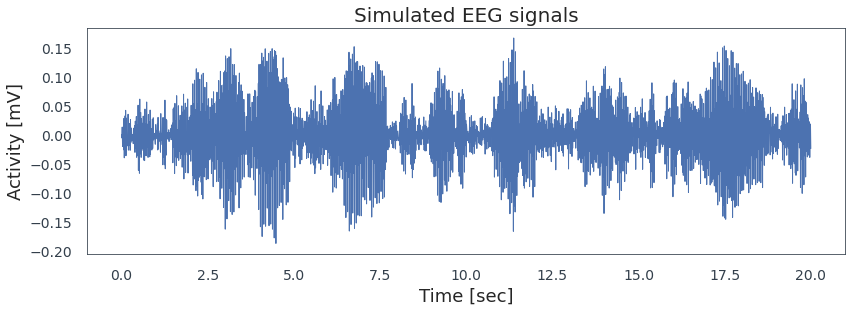

In [355]:
plt.figure(figsize=(12,4.5))
plt.plot(tss, EEG_sanity_ds[0,:].T, lw=1)
plt.title("Simulated EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

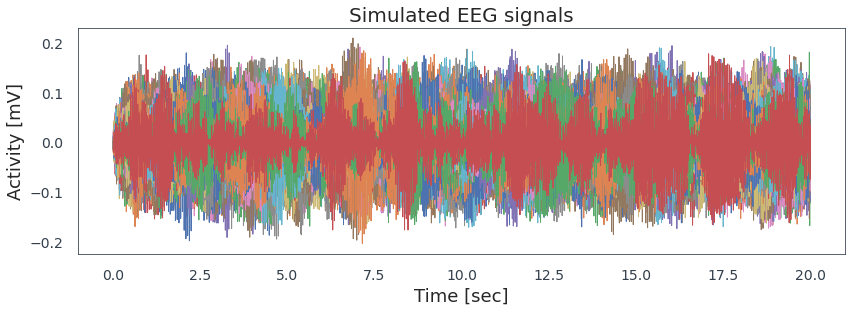

In [356]:
plt.figure(figsize=(12,4.5))
plt.plot(tss, EEG_sanity_ds.T, lw=1)
plt.title("Simulated EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [357]:
from scipy import signal
from scipy.signal import hilbert

In [358]:
fs = 10e3
f, Pxx_den =  signal.periodogram(EEG_sanity, fs)
analytic_signal = hilbert(EEG_sanity)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

In [359]:
Pxx_den.shape, f.shape, amplitude_envelope.shape

((84, 100001), (100001,), (84, 200001))

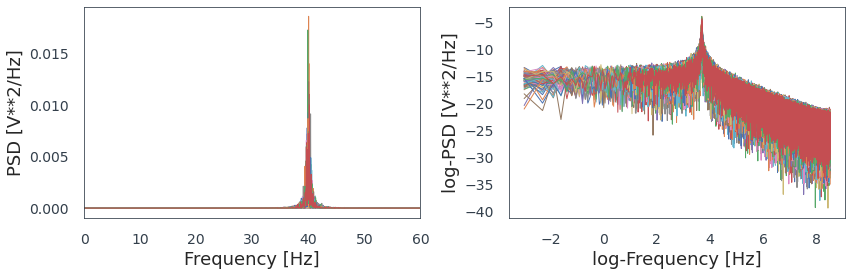

In [360]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in np.r_[0:nn]:
    plt.plot((f), (Pxx_den[i,:]), lw=1)
plt.xlabel('Frequency [Hz]',fontsize=18)
plt.ylabel('PSD [V**2/Hz]', fontsize=18)
plt.xlim([0,60])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(122)
for i in np.r_[0:nn]:
    plt.plot(np.log(f), np.log(Pxx_den[i,:]), lw=1)
plt.xlabel('log-Frequency [Hz]', fontsize=18)
plt.ylabel('log-PSD [V**2/Hz]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SpecytalPower.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SpecytalPower.eps"), doi=800)
plt.show()

In [361]:
Pxx_avg=np.mean(Pxx_den, axis=0)
Pxx_avg.shape

(100001,)

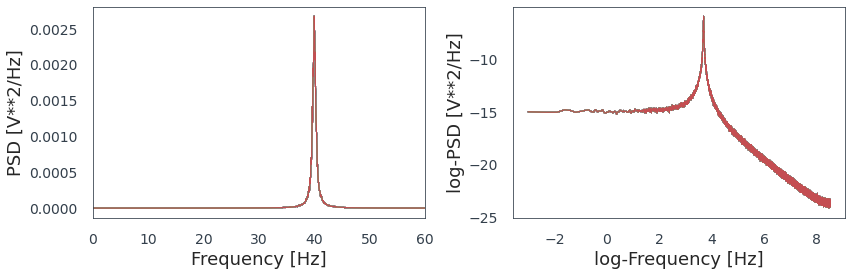

In [362]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in np.r_[0:nn]:
    plt.plot((f), (Pxx_avg), lw=1)
plt.xlabel('Frequency [Hz]',fontsize=18)
plt.ylabel('PSD [V**2/Hz]', fontsize=18)
plt.xlim([0,60])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(122)
for i in np.r_[0:nn]:
    plt.plot(np.log(f), np.log(Pxx_avg), lw=1)
plt.xlabel('log-Frequency [Hz]', fontsize=18)
plt.ylabel('log-PSD [V**2/Hz]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SpecytalPower_avg.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SpecytalPower_avg.eps"), doi=800)
plt.show()

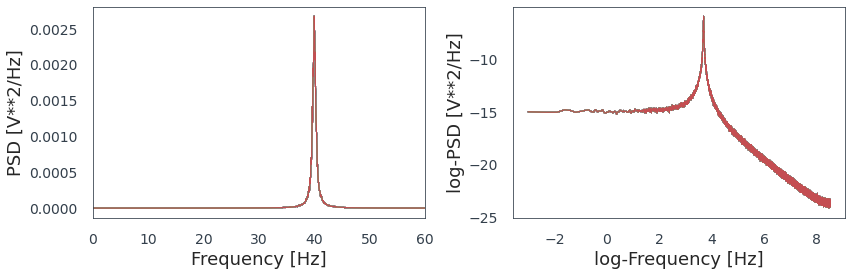

In [363]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in np.r_[0:nn]:
    plt.plot((f), (Pxx_avg), lw=1)
plt.xlabel('Frequency [Hz]',fontsize=18)
plt.ylabel('PSD [V**2/Hz]', fontsize=18)
plt.xlim([0,60])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(122)
for i in np.r_[0:nn]:
    plt.plot(np.log(f), np.log(Pxx_avg), lw=1)
plt.xlabel('log-Frequency [Hz]', fontsize=18)
plt.ylabel('log-PSD [V**2/Hz]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SpecytalPower_avg.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SpecytalPower_avg.eps"), doi=800)
plt.show()

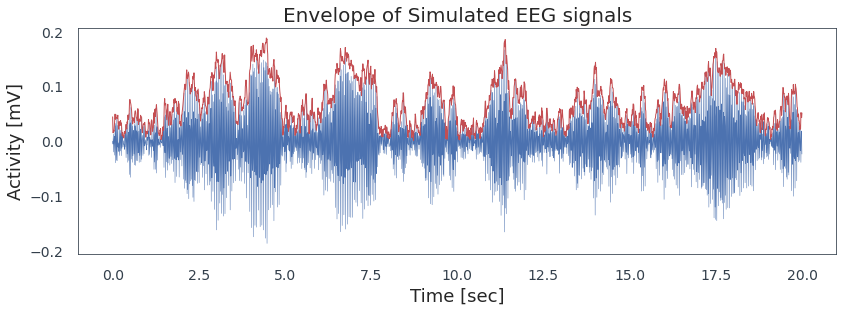

In [364]:
plt.figure(figsize=(12,4.5))
plt.plot(tss, EEG_sanity_ds[0,:].T, 'b', lw=.5)
plt.plot(tss, amplitude_envelope[0,::ds].T, 'r', lw=1)
plt.title("Envelope of Simulated EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_envelope.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_envelope.eps"), doi=800)
plt.show()

In [365]:
FCcorr=np.corrcoef(EEG_sanity_ds)
FCcorr.shape

(84, 84)

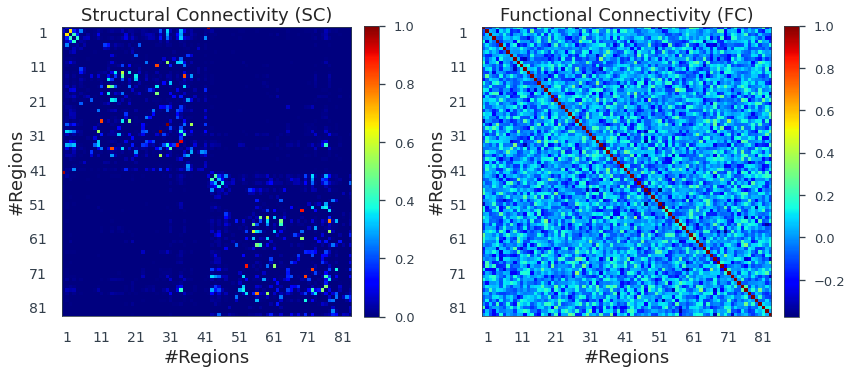

In [366]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Structural Connectivity (SC)', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Functional Connectivity (FC)', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SCFC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_SCFC.eps"), doi=800)
plt.show()

In [367]:
wwidth=30
maxNwindows=200
olap=0.94

In [368]:
FCDcorr,Pcorr,shift=extract_FCD(EEG_sanity_ds,wwidth,maxNwindows,olap,mode='corr')
FCDcorr.shape

(206, 206)

In [369]:
FCDcorr.var(), FCDcorr.sum(), 

(0.05659909779207396, 3944.9873466158715)

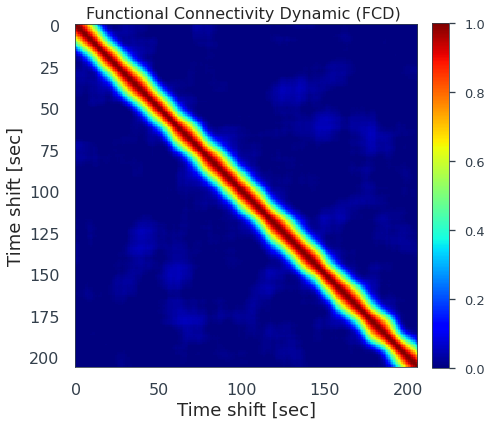

In [370]:
plt.figure(figsize=(7, 7))
plt.imshow(FCDcorr, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Functional Connectivity Dynamic (FCD) ', fontsize=16)
plt.ylabel('Time shift [sec]', fontsize=18.0)
plt.xlabel('Time shift [sec]', fontsize=18.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FCD.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FCD.eps"), doi=800)
plt.show()

In this example we use only statstical momenets ($m=4$) of the time series by default, and the summary statistics of FCD as well as FCD as the data features.

In [371]:
_=calculate_summary_statistics(EEG_, nn, features=['FC_corr', 'FCD_corr'])
print('feature shape:', _.shape)

feature shape: (162,)


### 2. Prior over model parameters

Here we provide a plausible ranges for the parameters that we aim to infer, by placing a uniform prior on them.

In [ ]:
prior_min_G=0.0*np.ones(1)

prior_max_G=1.0*np.ones(1)

In [ ]:
prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [ ]:
prior_min.shape, prior_max.shape

In [ ]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [ ]:
num_params=len(prior_min)
print('numumber of params :', num_params)

### Save simulations

Since running a large number of simulations is computationally expensive, we save the simulations generated from a random sampling of parameters through prior. This allows us to perform ad-hoc inference on the simulations to investigate the role of different features without re-simulation (amortized at patient level).

In [ ]:
num_sim=1000

In [ ]:
try:
    os.mkdir(Res_dir+'/output_simulations')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [ ]:
mysavepath = os.path.join(Res_dir, 'output_simulations/simulated_theta_x_GenericHopf.npz')
mysavepath

In [ ]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)

Since we place our simulator in another function, we need to run it for one simulation, for later beneficiation of JIT. In the saving step, the parameters are referred to as the vector theta, and the EEG signals as $x$ reshaped to vector (dimention will be $nn \times nt$). Finnaly, their dimention are: $theta \in [n_{sim} , n_{params}]$, and $ x \in [n_{sim},  nn \times nt] $. 


In [ ]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation took: %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation with JIT took: %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

### Load simulations and calculate features

Now we load the simulator output to calculate the data features

In [ ]:
loaded_simulations=np.load(mysavepath)

In [ ]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [ ]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

In [ ]:
if np.isfinite(np.sum(x_sim[0,:]))==True:
    _=calculate_summary_statistics(x_sim[0,:], nn, features=[ 'FC_corr', 'FCD_corr'])
    _.shape

num_features=_.shape[0]
print('feature shape:', num_features)

Now we are ready to provide the inputs as random sampled theta from prior (the set of parameters we aim to infer) and the features of observation x for inference (in torch tensor format). Given parameter $\theta$ and observation $x$, we can then sample from the posterior $p(\theta|x)$, evaluate its log-probability, or plot it. 

The dimention of theta is [number_simulations $\times$ number_parameters] and x is [number_simulations $\times$ number_features].

At the moments, SBI works only with float32.

In [ ]:
theta_features=np.zeros((num_sim,num_params))
x_features=np.zeros((num_sim,num_features))

In [ ]:
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

In [ ]:
start_time = time.time()

i = 0
while i < 2*num_sim:
       if np.isfinite(np.sum(x_sim))==True:
              theta_features[i,:]=theta_sim[i,:] 
              x_features[i,:]=calculate_summary_statistics(x_sim[i,:], nn, features=['FC_corr', 'FCD_corr'])
       if i == num_sim-1:
           break
       i += 1
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))    

In [ ]:
np.isnan(np.sum(x_features))

In [ ]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [ ]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

### 3. Inference

Finally we use Sequential Neural Posterior Estimation (SNPE) to sample from the posterior $p(\theta|x)$. The inputs are prior, parameter theta and (the data features of) observation x, and it returns us the posterior $p(\theta|x)$.

In [ ]:
inference = SNPE(prior, density_estimator='maf', device='cpu')

In [ ]:
start_time = time.time()

posterior_estimator = inference.append_simulations(theta, x).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

In [ ]:
## Without the saving and loading simulations, we can run sbi using the default function "infer", as follows:
##posterior = infer(GenericHopf_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

### Observed data set I (optimal G)

After the training NN, the posterior is amortized (i.e., no need to again train the neural network) and by providing the features of observation (empirical or simulated with same dimension as we used for training), we are able to efficiently obtain the posterior of parameters.

In the following we use different ground-truth values for simulation to validate the inference.

In [ ]:
G_true=0.25

In [ ]:
start_time = time.time()

EEG_obs_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_EEG, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

In [ ]:
obs_EEG_features=calculate_summary_statistics(EEG_obs_, nn, features=['FC_corr', 'FCD_corr'])

In [ ]:
obs_EEG_features.max()

In [ ]:
EEG_obs_.shape, obs_EEG_features.shape

In [ ]:
EEG_obs=EEG_obs_.reshape(nn, int(EEG_obs_.shape[0]/nn))
EEG_obs.shape

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(EEG_obs.T, lw=1)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs1.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_obs.shape

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs1.eps"), doi=800)
plt.show()

### Posterior of G for  data set I

In [ ]:
labels_params = [r'$G$']

In [ ]:
num_samples=2000

In [ ]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_EEG_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

In [ ]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs1.npy') , posterior_samples)

In [ ]:
posterior_samples.shape, params_true.shape

In [ ]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')


x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.eps"), doi=800)
plt.show()

In [ ]:
G_posterior.mean(), G_true

In [ ]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.eps"), doi=800)
plt.show()

In [ ]:
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
#np.percentile(posterior_sample, [50], axis=0)
EEG_fit_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_EEG, Tmax, ds)

In [ ]:
EEG_fit=EEG_fit_.reshape(nn, int(EEG_fit_.shape[0]/nn))

In [ ]:
np.save(os.path.join(Res_dir, 'EEG_obs1.npy') , EEG_obs)
np.save(os.path.join(Res_dir, 'EEG_fit1.npy') , EEG_fit)

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(EEG_obs.T)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(EEG_fit.T)
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(EEG_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(EEG_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_fit=np.corrcoef(EEG_fit)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.eps"), doi=800)
plt.show()

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(EEG_fit,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.eps"), doi=800)
plt.show()

In [ ]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

In [ ]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

In [ ]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [ ]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

In [ ]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

In [ ]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

# Another data set

### Observed data set II (low G)

In [ ]:
G_true=0.1

In [ ]:
start_time = time.time()

EEG_obs_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_EEG, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

In [ ]:
obs_EEG_features=calculate_summary_statistics(EEG_obs_, nn, features=['FC_corr', 'FCD_corr'])

In [ ]:
obs_EEG_features.max()

In [ ]:
EEG_obs_.shape, obs_EEG_features.shape

In [ ]:
EEG_obs=EEG_obs_.reshape(nn, int(EEG_obs_.shape[0]/nn))
EEG_obs.shape

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(EEG_obs.T, lw=1)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs2.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_obs.shape

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs2.eps"), doi=800)
plt.show()

### Posterior of G for  data set II

In [ ]:
labels_params = [r'$G$']

In [ ]:
num_samples=2000

In [ ]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_EEG_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

In [ ]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs2.npy') , posterior_samples)

In [ ]:
posterior_samples.shape, params_true.shape

In [ ]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.eps"), doi=800)
plt.show()

In [ ]:
G_posterior.mean(), G_true

In [ ]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.eps"), doi=800)
plt.show()

In [ ]:
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
#np.percentile(posterior_sample, [50], axis=0)
EEG_fit_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_EEG, Tmax, ds)

In [ ]:
EEG_fit=EEG_fit_.reshape(nn, int(EEG_fit_.shape[0]/nn))

In [ ]:
np.save(os.path.join(Res_dir, 'EEG_obs2.npy') , EEG_obs)
np.save(os.path.join(Res_dir, 'EEG_fit2.npy') , EEG_fit)

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(EEG_obs.T)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(EEG_fit.T)
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(EEG_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(EEG_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_fit=np.corrcoef(EEG_fit)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.eps"), doi=800)
plt.show()

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(EEG_fit,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.eps"), doi=800)
plt.show()

In [ ]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

In [ ]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

In [ ]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [ ]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

In [ ]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

In [ ]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

### Observed data set III (hight G)

In [ ]:
G_true=0.5

In [ ]:
start_time = time.time()

EEG_obs_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_EEG, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

In [ ]:
obs_EEG_features=calculate_summary_statistics(EEG_obs_, nn, features=['FC_corr', 'FCD_corr'])

In [ ]:
obs_EEG_features.max()

In [ ]:
EEG_obs_.shape, obs_EEG_features.shape

In [ ]:
EEG_obs=EEG_obs_.reshape(nn, int(EEG_obs_.shape[0]/nn))
EEG_obs.shape

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(EEG_obs.T, lw=1)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs3.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_obs.shape

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs3.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [ ]:
labels_params = [r'$G$']

In [ ]:
num_samples=2000

In [ ]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_EEG_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

In [ ]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs3.npy') , posterior_samples)

In [ ]:
posterior_samples.shape, params_true.shape

In [ ]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.eps"), doi=800)
plt.show()

In [ ]:
G_posterior.mean(), G_true

In [ ]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.eps"), doi=800)
plt.show()

In [ ]:
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
#np.percentile(posterior_sample, [50], axis=0)
EEG_fit_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_EEG, Tmax, ds)

In [ ]:
EEG_fit=EEG_fit_.reshape(nn, int(EEG_fit_.shape[0]/nn))

In [ ]:
np.save(os.path.join(Res_dir, 'EEG_obs3.npy') , EEG_obs)
np.save(os.path.join(Res_dir, 'EEG_fit3.npy') , EEG_fit)

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(EEG_obs.T)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(EEG_fit.T)
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(EEG_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(EEG_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_fit=np.corrcoef(EEG_fit)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.eps"), doi=800)
plt.show()

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(EEG_fit,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.eps"), doi=800)
plt.show()

In [ ]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

In [ ]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

In [ ]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [ ]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

In [ ]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

In [ ]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

### Observed data set IIII (very hight G)

In [ ]:
G_true=0.75

In [ ]:
start_time = time.time()

EEG_obs_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_true, SC,  dt, dt_EEG, Tmax, ds)

print(" single sim (sec) takes:" , (time.time() - start_time))

In [ ]:
obs_EEG_features=calculate_summary_statistics(EEG_obs_, nn, features=['FC_corr', 'FCD_corr'])

In [ ]:
obs_EEG_features.max()

In [ ]:
EEG_obs_.shape, obs_EEG_features.shape

In [ ]:
EEG_obs=EEG_obs_.reshape(nn, int(EEG_obs_.shape[0]/nn))
EEG_obs.shape

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(EEG_obs.T, lw=1)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_obs4.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_obs.shape

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedEEG_sanity_FC_FCD_obs4.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [ ]:
labels_params = [r'$G$']

In [ ]:
num_samples=2000

In [ ]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_EEG_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

In [ ]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs4.npy') , posterior_samples)

In [ ]:
posterior_samples.shape, params_true.shape

In [ ]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.eps"), doi=800)
plt.show()

In [ ]:
G_posterior.mean(), G_true

In [ ]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.eps"), doi=800)
plt.show()

In [ ]:
np.percentile(posterior_samples, [5, 95], axis=0)

In [ ]:
#np.percentile(posterior_sample, [50], axis=0)
EEG_fit_ =GenericHopfEEG(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_EEG, Tmax, ds)

In [ ]:
EEG_fit=EEG_fit_.reshape(nn, int(EEG_fit_.shape[0]/nn))

In [ ]:
np.save(os.path.join(Res_dir, 'EEG_obs4.npy') , EEG_obs)
np.save(os.path.join(Res_dir, 'EEG_fit4.npy') , EEG_fit)

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(EEG_obs.T)
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(EEG_fit.T)
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(EEG_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(EEG_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted EEG signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.eps"), doi=800)
plt.show()

In [ ]:
FCcorr_obs=np.corrcoef(EEG_obs)
FCcorr_fit=np.corrcoef(EEG_fit)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.eps"), doi=800)
plt.show()

In [ ]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(EEG_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(EEG_fit,wwidth,maxNwindows,olap,mode='corr')

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.eps"), doi=800)
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.eps"), doi=800)
plt.show()

In [ ]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

In [ ]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

In [ ]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [ ]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

In [ ]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

In [ ]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

In [ ]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))